## データ拡張を行う特徴抽出

### たたみ込みベースに全結合分類期を追加

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))

import os
import numpy as np
import pandas as pd

mini_metadata = pd.read_csv('mini_metadata.csv',index_col=0)
classes = list(mini_metadata["make_model"].value_counts().index)
classes = sorted(classes)
classes_num = len(mini_metadata.groupby("make_model"))

base_dir = 'mini_pictures'

train_dir = os.path.join(base_dir,'train')
valid_dir = os.path.join(base_dir,'valid')
test_dir = os.path.join(base_dir,'test')

Using TensorFlow backend.


In [2]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(classes_num, activation='softmax'))

In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_2 (Dense)              (None, 20)                5140      
Total params: 23,108,692
Trainable params: 23,108,692
Non-trainable params: 0
_________________________________________________________________


In [4]:
print('This is the number of trainable weights')
print('before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights
before freezing the conv base: 30


In [5]:
conv_base.trainable = False

In [6]:
print('This is the number of trainable weights')
print('after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights
after freezing the conv base: 4


### 凍結されたたたみ込みベースを使ってモデル全体を訓練

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     fill_mode='nearest'
)

# 検証データは水増しするべきで無いことに注意
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,               #ターゲットディレクトリ
    target_size=(256,256),   #全ての画像を256*256に変換
    batch_size=32,           #バッチサイズ
    class_mode='categorical',#損失関数としてcategorical_crossentropyを使用するため,
    classes=classes          #他クラスラベルが必要
    )

validation_generator = test_datagen.flow_from_directory(
    valid_dir,               #ターゲットディレクトリ
    target_size=(256,256),   #全ての画像を256*256に変換
    batch_size=32,           #バッチサイズ
    class_mode='categorical',#損失関数としてcategorical_crossentropyを使用するため,
    classes=classes          #他クラスラベルが必要
    )

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='categorical_crossentropy',
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)


Found 1912 images belonging to 20 classes.
Found 657 images belonging to 20 classes.
Epoch 1/30
 - 3601s - loss: 2.4818 - acc: 0.3216 - val_loss: 2.0486 - val_acc: 0.5516
Epoch 2/30
 - 3535s - loss: 1.6635 - acc: 0.6491 - val_loss: 1.6314 - val_acc: 0.6955
Epoch 3/30
 - 3453s - loss: 1.1599 - acc: 0.8106 - val_loss: 0.9694 - val_acc: 0.7685
Epoch 4/30
 - 2831s - loss: 0.8180 - acc: 0.9004 - val_loss: 0.8605 - val_acc: 0.8210
Epoch 5/30
 - 1895s - loss: 0.5860 - acc: 0.9414 - val_loss: 0.6968 - val_acc: 0.8401
Epoch 6/30
 - 1899s - loss: 0.4404 - acc: 0.9658 - val_loss: 0.6513 - val_acc: 0.8849
Epoch 7/30
 - 1926s - loss: 0.3216 - acc: 0.9799 - val_loss: 0.5617 - val_acc: 0.9115
Epoch 8/30
 - 1892s - loss: 0.2399 - acc: 0.9893 - val_loss: 0.5498 - val_acc: 0.9363
Epoch 9/30
 - 1898s - loss: 0.1851 - acc: 0.9921 - val_loss: 0.3401 - val_acc: 0.9452
Epoch 10/30
 - 1897s - loss: 0.1388 - acc: 0.9962 - val_loss: 0.2660 - val_acc: 0.9522
Epoch 11/30
 - 1891s - loss: 0.1047 - acc: 0.9994 - va

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.figure()

#損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validatin loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

## ファインチューニング

特徴抽出に用いられる凍結されたたたみ込みベースの出力層をいくつか解凍し、モデルの新しく追加された部分と、解凍した層の両方で訓練を行う

* 訓練済みベースネットワークの最後にカスタムネットワークを追加する
* ベースネットワークを凍結する
* 追加した部分の訓練を行う
* ベースネットワークの一部を解凍する
* 凍結した層と追加した部分の訓練を同時に行う

上で３つ目までが終わっているので、４の、たたみ込みベース(conv_base)を解凍し、その中に含まれる層を個別に凍結する

In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

### ファインチューニングを行うのは最後の２つか３つの層のみ!
つまり、block4_poolまでの層は全て凍結される。

block5_conv1,block5_conv2,block5_conv3の３つの層が訓練可能になる

In [10]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [11]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),#学習率が低いのはファインチューニングを行う３つの層の変更を制限するため
             loss='categorical_crossentropy',
             metrics=['acc'])

In [14]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=50)

Epoch 1/30
100/100 [==============================] - 3728s 37s/step - loss: 4.9962e-04 - acc: 0.9997 - val_loss: 0.0653 - val_acc: 0.9936
Epoch 2/30
100/100 [==============================] - 3562s 36s/step - loss: 1.3562e-04 - acc: 1.0000 - val_loss: 0.1307 - val_acc: 0.9930
Epoch 3/30
100/100 [==============================] - 2193s 22s/step - loss: 8.6592e-06 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 0.9961
Epoch 4/30
100/100 [==============================] - 2109s 21s/step - loss: 1.1728e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 0.9962
Epoch 5/30
100/100 [==============================] - 2102s 21s/step - loss: 1.2519e-06 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 0.9943
Epoch 6/30
100/100 [==============================] - 2100s 21s/step - loss: 4.4568e-05 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 0.9974
Epoch 7/30
100/100 [==============================] - 2115s 21s/step - loss: 5.7257e-07 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 0.9981
Epoch 8/30
100/100 [=======

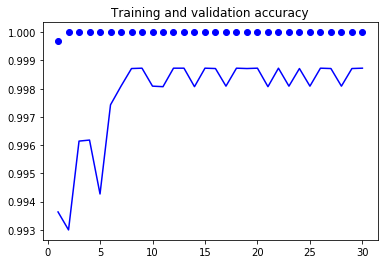

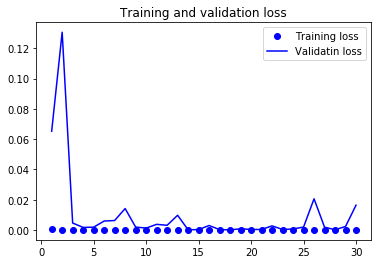

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.figure()

#損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validatin loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
model.save("VGG16_extended_mini_1.h5")